In [17]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

import pickle
import os

In [18]:
### Load results.pickle
with open(os.path.join('..', 'Modeling', 'results.pickle'), 'rb') as file:
    all_results = pickle.load(file)

In [19]:
### Helper functions
def get_ovr(desired_class, classes, y_true, y_predicted_probabilities):
    """Returns y_true and y_predicted_probabilities scores for a specified class vs the remaining classes"""
    # get a dictionary mapping labels to indices
    labels_dict = dict(zip(classes, range(len(classes))))
    # find the index of the desired class
    desired_class_index = labels_dict[desired_class]
    # one-hot encode y_true
    binarizer = LabelBinarizer().fit(classes)
    y_true_onehot = binarizer.transform(y_true)
    # print(y_predicted_probabilities)
    # return the results
    # if multiclass
    if len(classes) > 2:
        return y_true_onehot[:, desired_class_index], y_predicted_probabilities[:, desired_class_index]
    # if binary
    else:
        # return default positive class information
        if desired_class_index == 1:
            return y_true_onehot[:, 0], y_predicted_probabilities[:, desired_class_index]
        # return default negative class information
        elif desired_class_index == 0:
            return 1 - y_true_onehot[:, 0], y_predicted_probabilities[:, desired_class_index]
        else:
            raise Exception("Invalid value for desired_class_index in a binary classifier setting")


In [20]:
### Prepare data for plotting
plot_data = dict()
# for each classification task, display a ROC curve for RL identification
for classification_task, classifier in all_results.keys():
    # if not already a key, make classification_task a key in the plot_data dict
    if classification_task not in plot_data:
        plot_data[classification_task] = dict()
    # get classes, string encoded true values and predictions, and predicted probabilities
    classes = all_results[(classification_task, classifier)]['final_results']['classes']
    y_true = all_results[(classification_task, classifier)]['final_results']['y_true']
    y_pred = all_results[(classification_task, classifier)]['final_results']['y_predicted']
    y_prob = all_results[(classification_task, classifier)]['final_results']['y_predicted_probabilities']
    # select the reactive-lymph associated values and predictions for plotting AUC curves
    y_true_rl, y_prob_rl = get_ovr('Reactive Lymphs', classes, y_true, y_prob)
    # store this information in the plot_data dictionary for easy comparison with other model on the same prediction task
    plot_data[classification_task][classifier] = {'y_true_rl' : y_true_rl, 'y_prob_rl' : y_prob_rl}

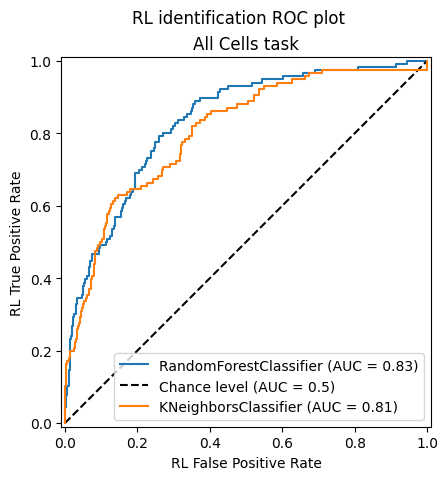

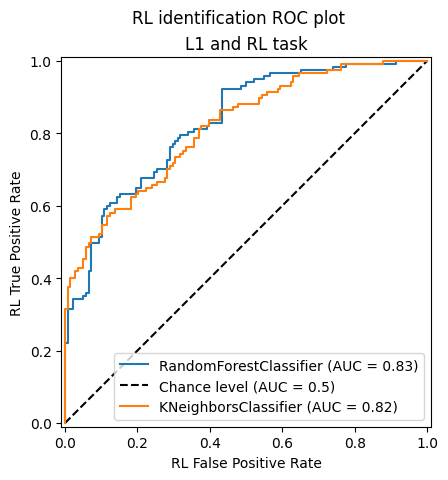

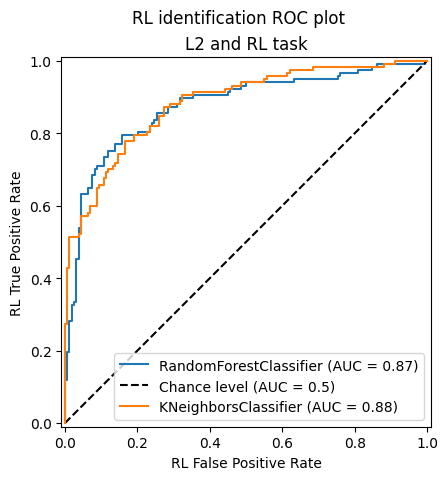

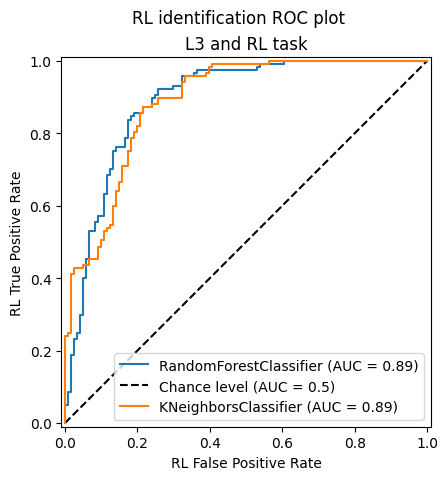

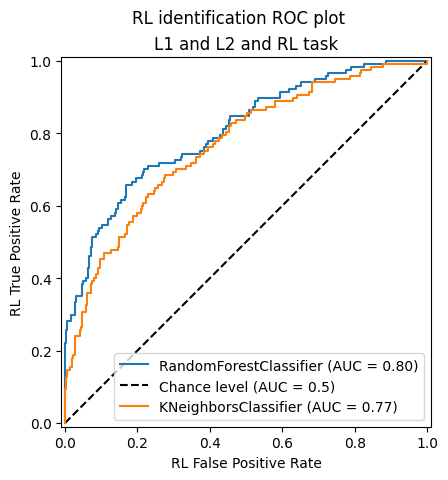

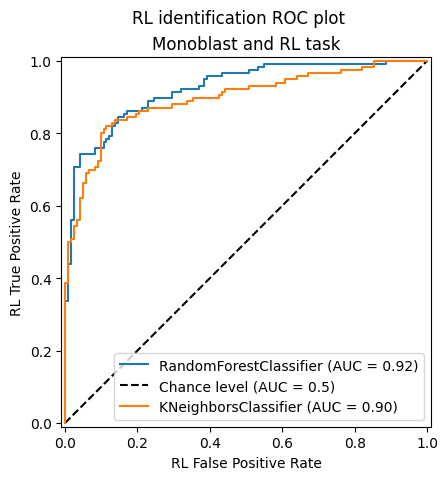

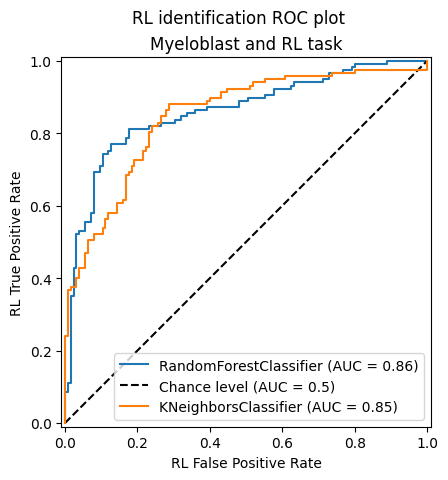

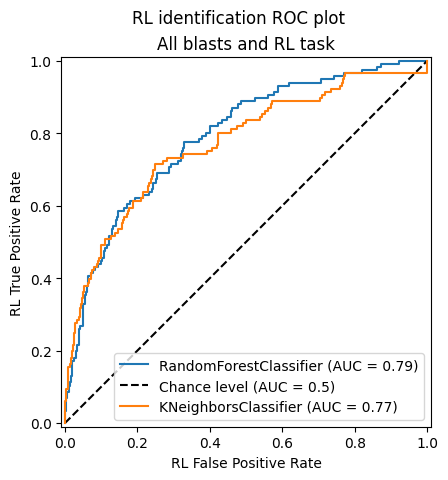

In [21]:
### Plot AUC curves for each classification task
for classification_task, data in plot_data.items():
    fig = plt.figure()
    ax = fig.gca()
    counter = 0
    for classifier, classifier_data in data.items():
        y_true_rl = classifier_data['y_true_rl']
        y_prob_rl = classifier_data['y_prob_rl']
        plot_chance = True if counter == 0 else False
        RocCurveDisplay.from_predictions(y_true_rl, y_prob_rl, name=classifier, plot_chance_level=plot_chance, ax=ax, drawstyle='steps-post')
        counter += 1
    plt.title(f"{classification_task} task")
    plt.suptitle("RL identification ROC plot")
    plt.xlabel("RL False Positive Rate")
    plt.ylabel("RL True Positive Rate")
    plt.savefig(f"auc_curves/{classification_task}.png", dpi=600)
    plt.show()